<a href="https://colab.research.google.com/github/fatalistix/smgmo/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from tqdm import tqdm

import scipy

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score

In [ ]:
class CB1(nn.Module):
  def __init__(
      self,
      in_channels: int,
      out_channels: int,
      conv_kernel_size: int = 3,
      conv_stride: int = 1,
      conv_padding: int = 1,
      pool_kernel_size: int = 2,
      pool_stride: int = 2,
      pool_padding: int = 1):
    super(CB1, self).__init__()
    self.stack = nn.Sequential(
        nn.Conv2d(in_channels,
                  out_channels,
                  kernel_size=conv_kernel_size,
                  stride=conv_stride,
                  padding=conv_padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=pool_kernel_size,
                     stride=pool_stride,
                     padding=pool_padding)
    )

  def forward(self, x):
    return self.stack(x)

In [ ]:
class CB2(nn.Module):
  def __init__(
      self,
      in_channels: int,
      out_channels: int,
      conv_kernel_size: int = 3,
      conv_stride: int = 1,
      conv_padding: int = 1,
      pool_kernel_size: int = 2,
      pool_stride: int = 2,
      pool_padding: int = 1):
    super(CB2, self).__init__()
    self.stack = nn.Sequential(
        nn.Conv2d(in_channels,
                  out_channels // 2,
                  kernel_size = conv_kernel_size,
                  stride=conv_stride,
                  padding=conv_padding),
        nn.ReLU(),
        nn.Conv2d(out_channels // 2,
                  out_channels,
                  kernel_size=conv_kernel_size,
                  stride=conv_stride,
                  padding=conv_padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=pool_kernel_size,
                     stride=pool_stride,
                     padding=pool_padding)
    )

  def forward(self, x):
    return self.stack(x)

In [ ]:
class CNN(nn.Module):
  def __init__(self, blocks: list[nn.Module], linear_in: int, linear_out: int):
    super(CNN, self).__init__()

    self.stack = nn.Sequential(
      *blocks,
      nn.Flatten(),
      nn.Linear(linear_in, linear_out)
    )

  def forward(self, x):
    out = self.stack(x)
    return out

In [ ]:
train_dataset = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=transforms.ToTensor(),
)
test_dataset = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=transforms.ToTensor(),
)

100%|██████████| 26421880/26421880 [00:14<00:00, 1801049.83it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 124594.03it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1127420.92it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5430653.17it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



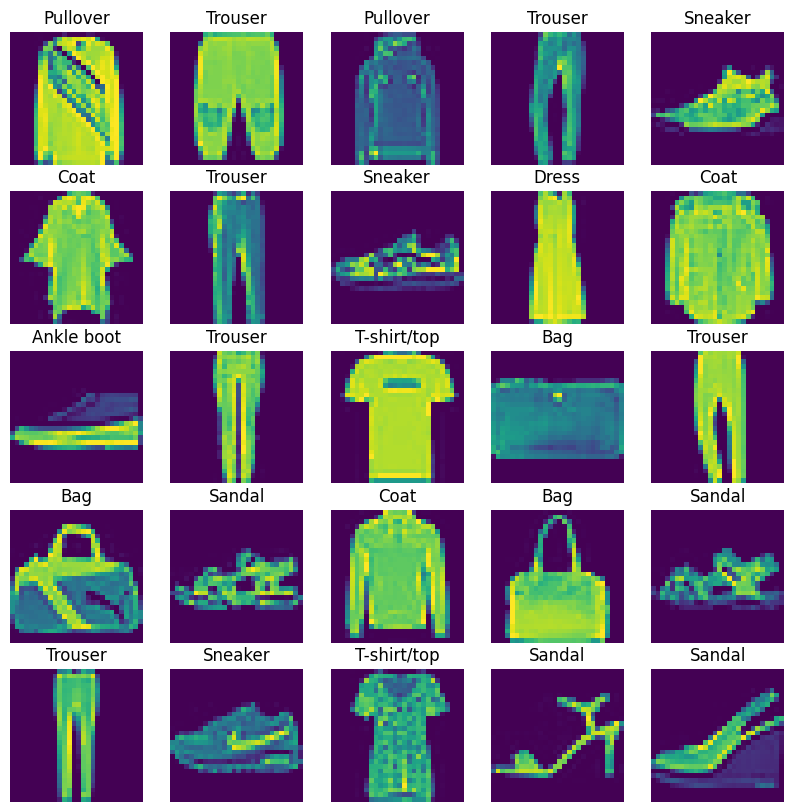

In [ ]:
train_subdataset = Subset(train_dataset, range(4000))
test_subdataset = Subset(test_dataset, range(500))

torch.manual_seed(734)
figure = plt.figure(figsize=(10, 10))
rows, columns = 5, 5
for i in range(1, rows * columns + 1):
  idx = torch.randint(0, len(train_dataset), size=[1]).item()
  img, label = train_dataset[idx]
  figure.add_subplot(rows, columns, i)
  plt.imshow(img.squeeze())
  plt.title(train_dataset.classes[label])
  plt.axis(False)

plt.show()

In [ ]:
batch_size = 100
train_dataloader = DataLoader(
    dataset=train_subdataset, batch_size=batch_size, shuffle=True, drop_last=True
)
test_dataloader = DataLoader(
    dataset=test_subdataset, batch_size=1, shuffle=True, drop_last=True
)

In [ ]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
print(device)

cuda


In [ ]:
def fit(model: nn.Module, device, train_dataloader, test_dataloader, optimizer, criterion, epochs):
  model.to(device)

  for epoch in tqdm(range(epochs)):
    model.train()

    for img, label in train_dataloader:
      img, label = img.to(device), label.to(device)

      optimizer.zero_grad()

      pred = model(img)

      loss = criterion(pred, label)

      loss.backward()
      optimizer.step()

    if (epoch + 1) % 1 == 0:
      precision = precision_score(label.cpu().numpy(), np.argmax(model(img).cpu().detach().numpy(), axis=1), average='micro')
      accuracy = accuracy_score(label.cpu().numpy(), np.argmax(model(img).cpu().detach().numpy(), axis=1))
      print(f'Epoch[{epoch+1}/{epochs}], Loss: {loss}, accuracy: {accuracy}, precision: {precision}')

  model.eval()
  result_accuracy = 0
  result_precision = 0
  with torch.no_grad():
    for img, label in test_dataloader:
      img, label = img.to(device), label.to(device)
      pred = model(img)
      result_accuracy += accuracy_score(label.cpu().numpy(), np.argmax(model(img).cpu().detach().numpy(), axis=1))
      result_precision += precision_score(label.cpu().numpy(), np.argmax(model(img).cpu().detach().numpy(), axis=1), average='micro')

  print(f'test accuracy: {result_accuracy / len(test_dataloader)}, test precision: {result_precision / len(test_dataloader)}')

In [ ]:
model = CNN([CB2(1, 32, 3, 1, 1, 2, 2, 0)], 32*7*7*4, 10)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

CNN(
  (stack): Sequential(
    (0): CB2(
      (stack): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=6272, out_features=10, bias=True)
  )
)


In [ ]:
fit(model, device, train_dataloader, test_dataloader, optimizer, criterion, 15)
# for img, label in train_dataloader:
#   test_model = CB1(1, 32, 3, 1, 1, 3, 1, 1)
#   print(test_model(img).shape)
#   break

  0%|          | 0/15 [00:05<?, ?it/s]


KeyboardInterrupt: 

Precision: 0.8893981766895178, Accuracy: 0.89


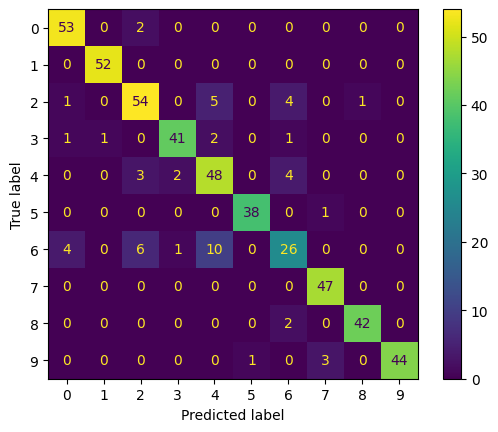

In [ ]:
model.eval()

preds = []
target = []

with torch.no_grad():
  model.to(device)
  for (img, label) in test_dataloader:
    target.append(label)
    pred = model(img.to(device))
    preds.append(np.argmax(pred.cpu().detach().numpy()))

cm = confusion_matrix(target, preds)
ConfusionMatrixDisplay(cm).plot()

precision = precision_score(target, preds, average='weighted')
accuracy = accuracy_score(target, preds)

print(f'Precision: {precision}, Accuracy: {accuracy}')

In [ ]:
def train_test(model: nn.Module, epochs: int, lr: float) -> (float, float):
  print(model)

  torch.manual_seed(734)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  fit(model, device, train_dataloader, test_dataloader, optimizer, criterion, epochs)

  model.eval()

  preds = []
  target = []

  with torch.no_grad():
    model.to(device)
    for (img, label) in test_dataloader:
      target.append(label)
      pred = model(img.to(device))
      preds.append(np.argmax(pred.cpu().detach().numpy()))

  cm = confusion_matrix(target, preds)
  ConfusionMatrixDisplay(cm).plot()

  precision = precision_score(target, preds, average='micro')
  accuracy = accuracy_score(target, preds)

  print(f'Precision: {precision}, Accuracy: {accuracy}')
  return precision, accuracy

CNN(
  (stack): Sequential(
    (0): CB2(
      (stack): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=6272, out_features=10, bias=True)
  )
)


  7%|▋         | 1/15 [00:00<00:06,  2.13it/s]

Epoch[1/15], Loss: 0.5161948204040527, accuracy: 0.83, precision: 0.83


 13%|█▎        | 2/15 [00:00<00:06,  2.09it/s]

Epoch[2/15], Loss: 0.6309604048728943, accuracy: 0.82, precision: 0.82


 20%|██        | 3/15 [00:01<00:05,  2.07it/s]

Epoch[3/15], Loss: 0.4558027982711792, accuracy: 0.85, precision: 0.85


 27%|██▋       | 4/15 [00:01<00:05,  2.07it/s]

Epoch[4/15], Loss: 0.3957217335700989, accuracy: 0.87, precision: 0.87


 33%|███▎      | 5/15 [00:02<00:04,  2.06it/s]

Epoch[5/15], Loss: 0.45875075459480286, accuracy: 0.91, precision: 0.91


 40%|████      | 6/15 [00:02<00:04,  2.06it/s]

Epoch[6/15], Loss: 0.4933911859989166, accuracy: 0.85, precision: 0.85


 47%|████▋     | 7/15 [00:03<00:03,  2.04it/s]

Epoch[7/15], Loss: 0.290540874004364, accuracy: 0.88, precision: 0.88


 53%|█████▎    | 8/15 [00:03<00:03,  2.05it/s]

Epoch[8/15], Loss: 0.29072752594947815, accuracy: 0.89, precision: 0.89


 60%|██████    | 9/15 [00:04<00:02,  2.05it/s]

Epoch[9/15], Loss: 0.34178000688552856, accuracy: 0.92, precision: 0.92


 67%|██████▋   | 10/15 [00:04<00:02,  2.05it/s]

Epoch[10/15], Loss: 0.20464827120304108, accuracy: 0.93, precision: 0.93


 73%|███████▎  | 11/15 [00:05<00:02,  1.84it/s]

Epoch[11/15], Loss: 0.2420540452003479, accuracy: 0.91, precision: 0.91


 80%|████████  | 12/15 [00:06<00:01,  1.73it/s]

Epoch[12/15], Loss: 0.2360970675945282, accuracy: 0.93, precision: 0.93


 87%|████████▋ | 13/15 [00:06<00:01,  1.58it/s]

Epoch[13/15], Loss: 0.2695918679237366, accuracy: 0.91, precision: 0.91


 93%|█████████▎| 14/15 [00:07<00:00,  1.59it/s]

Epoch[14/15], Loss: 0.34857669472694397, accuracy: 0.9, precision: 0.9


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]

Epoch[15/15], Loss: 0.18650947511196136, accuracy: 0.92, precision: 0.92


test accuracy: 0.872, test precision: 0.872
Precision: 0.872, Accuracy: 0.872


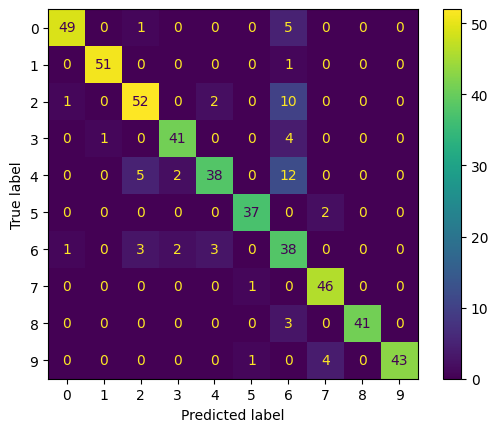

In [ ]:
train_test(CNN([CB2(1, 32, 3, 1, 1, 2, 2, 0)], 32*7*7*4, 10), 15, 0.001)

CNN(
  (stack): Sequential(
    (0): CB1(
      (stack): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=6272, out_features=10, bias=True)
  )
)


  7%|▋         | 1/15 [00:00<00:13,  1.06it/s]

Epoch[1/15], Loss: 0.5629842877388, accuracy: 0.86, precision: 0.86


 13%|█▎        | 2/15 [00:02<00:16,  1.30s/it]

Epoch[2/15], Loss: 0.5897624492645264, accuracy: 0.85, precision: 0.85


 20%|██        | 3/15 [00:04<00:18,  1.55s/it]

Epoch[3/15], Loss: 0.4597187936306, accuracy: 0.86, precision: 0.86


 27%|██▋       | 4/15 [00:05<00:15,  1.41s/it]

Epoch[4/15], Loss: 0.4011080265045166, accuracy: 0.86, precision: 0.86


 33%|███▎      | 5/15 [00:06<00:12,  1.29s/it]

Epoch[5/15], Loss: 0.4882458448410034, accuracy: 0.9, precision: 0.9


 40%|████      | 6/15 [00:07<00:09,  1.06s/it]

Epoch[6/15], Loss: 0.5026014447212219, accuracy: 0.86, precision: 0.86


 47%|████▋     | 7/15 [00:07<00:06,  1.15it/s]

Epoch[7/15], Loss: 0.31719863414764404, accuracy: 0.9, precision: 0.9


 53%|█████▎    | 8/15 [00:08<00:05,  1.35it/s]

Epoch[8/15], Loss: 0.3352207839488983, accuracy: 0.87, precision: 0.87


 60%|██████    | 9/15 [00:08<00:03,  1.52it/s]

Epoch[9/15], Loss: 0.3268510699272156, accuracy: 0.9, precision: 0.9


 67%|██████▋   | 10/15 [00:09<00:03,  1.66it/s]

Epoch[10/15], Loss: 0.21357320249080658, accuracy: 0.92, precision: 0.92


 73%|███████▎  | 11/15 [00:09<00:02,  1.79it/s]

Epoch[11/15], Loss: 0.24912764132022858, accuracy: 0.93, precision: 0.93


 80%|████████  | 12/15 [00:10<00:01,  1.88it/s]

Epoch[12/15], Loss: 0.2600719630718231, accuracy: 0.91, precision: 0.91


 87%|████████▋ | 13/15 [00:10<00:01,  1.94it/s]

Epoch[13/15], Loss: 0.30710721015930176, accuracy: 0.89, precision: 0.89


 93%|█████████▎| 14/15 [00:11<00:00,  1.98it/s]

Epoch[14/15], Loss: 0.3636551797389984, accuracy: 0.91, precision: 0.91


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]

Epoch[15/15], Loss: 0.2063181847333908, accuracy: 0.93, precision: 0.93


test accuracy: 0.88, test precision: 0.88
Precision: 0.88, Accuracy: 0.88


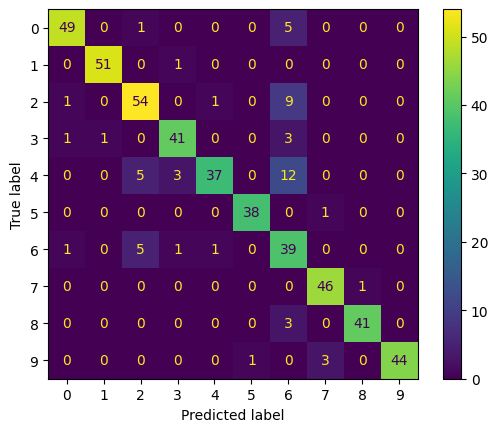

In [ ]:
train_test(CNN([CB1(1, 32, 3, 1, 1, 2, 2, 0)], 32*7*7*4, 10), 15, 0.001)

CNN(
  (stack): Sequential(
    (0): CB2(
      (stack): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=6272, out_features=10, bias=True)
  )
)


  7%|▋         | 1/15 [00:01<00:17,  1.25s/it]

Epoch[1/15], Loss: 0.5161939859390259, accuracy: 0.83, precision: 0.83


 13%|█▎        | 2/15 [00:03<00:21,  1.67s/it]

Epoch[2/15], Loss: 0.6308461427688599, accuracy: 0.82, precision: 0.82


 20%|██        | 3/15 [00:03<00:14,  1.25s/it]

Epoch[3/15], Loss: 0.45605796575546265, accuracy: 0.85, precision: 0.85


 27%|██▋       | 4/15 [00:04<00:10,  1.06it/s]

Epoch[4/15], Loss: 0.3956243395805359, accuracy: 0.87, precision: 0.87


 33%|███▎      | 5/15 [00:04<00:07,  1.27it/s]

Epoch[5/15], Loss: 0.45898139476776123, accuracy: 0.91, precision: 0.91


 40%|████      | 6/15 [00:05<00:06,  1.45it/s]

Epoch[6/15], Loss: 0.49363309144973755, accuracy: 0.85, precision: 0.85


 47%|████▋     | 7/15 [00:05<00:05,  1.59it/s]

Epoch[7/15], Loss: 0.29010826349258423, accuracy: 0.89, precision: 0.89


 53%|█████▎    | 8/15 [00:06<00:04,  1.71it/s]

Epoch[8/15], Loss: 0.2914467751979828, accuracy: 0.89, precision: 0.89


 60%|██████    | 9/15 [00:06<00:03,  1.80it/s]

Epoch[9/15], Loss: 0.34231844544410706, accuracy: 0.92, precision: 0.92


 67%|██████▋   | 10/15 [00:07<00:02,  1.88it/s]

Epoch[10/15], Loss: 0.20490533113479614, accuracy: 0.93, precision: 0.93


 73%|███████▎  | 11/15 [00:07<00:02,  1.92it/s]

Epoch[11/15], Loss: 0.2416374832391739, accuracy: 0.92, precision: 0.92


 80%|████████  | 12/15 [00:08<00:01,  1.96it/s]

Epoch[12/15], Loss: 0.23549631237983704, accuracy: 0.93, precision: 0.93


 87%|████████▋ | 13/15 [00:08<00:01,  1.98it/s]

Epoch[13/15], Loss: 0.2701714038848877, accuracy: 0.9, precision: 0.9


 93%|█████████▎| 14/15 [00:09<00:00,  1.94it/s]

Epoch[14/15], Loss: 0.34655818343162537, accuracy: 0.9, precision: 0.9


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

Epoch[15/15], Loss: 0.18712207674980164, accuracy: 0.92, precision: 0.92


test accuracy: 0.87, test precision: 0.87
Precision: 0.87, Accuracy: 0.87
CNN(
  (stack): Sequential(
    (0): CB2(
      (stack): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=6272, out_features=10, bias=True)
  )
)


  7%|▋         | 1/15 [00:00<00:06,  2.10it/s]

Epoch[1/15], Loss: 0.48094725608825684, accuracy: 0.84, precision: 0.84


 13%|█▎        | 2/15 [00:00<00:06,  2.06it/s]

Epoch[2/15], Loss: 0.545505166053772, accuracy: 0.86, precision: 0.86


 20%|██        | 3/15 [00:01<00:05,  2.06it/s]

Epoch[3/15], Loss: 0.3797862231731415, accuracy: 0.89, precision: 0.89


 27%|██▋       | 4/15 [00:01<00:05,  2.02it/s]

Epoch[4/15], Loss: 0.2732168734073639, accuracy: 0.92, precision: 0.92


 33%|███▎      | 5/15 [00:02<00:05,  1.77it/s]

Epoch[5/15], Loss: 0.298831582069397, accuracy: 0.91, precision: 0.91


 40%|████      | 6/15 [00:03<00:05,  1.66it/s]

Epoch[6/15], Loss: 0.2622435390949249, accuracy: 0.9, precision: 0.9


 47%|████▋     | 7/15 [00:04<00:05,  1.53it/s]

Epoch[7/15], Loss: 0.16233810782432556, accuracy: 0.96, precision: 0.96


 53%|█████▎    | 8/15 [00:04<00:04,  1.56it/s]

Epoch[8/15], Loss: 0.15335313975811005, accuracy: 0.97, precision: 0.97


 60%|██████    | 9/15 [00:05<00:03,  1.68it/s]

Epoch[9/15], Loss: 0.23464132845401764, accuracy: 0.92, precision: 0.92


 67%|██████▋   | 10/15 [00:05<00:02,  1.79it/s]

Epoch[10/15], Loss: 0.10472078621387482, accuracy: 0.98, precision: 0.98


 73%|███████▎  | 11/15 [00:06<00:02,  1.85it/s]

Epoch[11/15], Loss: 0.1403871327638626, accuracy: 0.96, precision: 0.96


 80%|████████  | 12/15 [00:06<00:01,  1.89it/s]

Epoch[12/15], Loss: 0.16422823071479797, accuracy: 0.96, precision: 0.96


 87%|████████▋ | 13/15 [00:07<00:01,  1.93it/s]

Epoch[13/15], Loss: 0.12130127847194672, accuracy: 0.95, precision: 0.95


 93%|█████████▎| 14/15 [00:07<00:00,  1.96it/s]

Epoch[14/15], Loss: 0.15520992875099182, accuracy: 0.98, precision: 0.98


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]

Epoch[15/15], Loss: 0.09058359265327454, accuracy: 0.98, precision: 0.98


test accuracy: 0.858, test precision: 0.858
Precision: 0.858, Accuracy: 0.858
CNN(
  (stack): Sequential(
    (0): CB2(
      (stack): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=6272, out_features=10, bias=True)
  )
)


  7%|▋         | 1/15 [00:00<00:06,  2.03it/s]

Epoch[1/15], Loss: 0.43178585171699524, accuracy: 0.84, precision: 0.84


 13%|█▎        | 2/15 [00:00<00:06,  2.04it/s]

Epoch[2/15], Loss: 0.5845247507095337, accuracy: 0.85, precision: 0.85


 20%|██        | 3/15 [00:01<00:05,  2.04it/s]

Epoch[3/15], Loss: 0.38727837800979614, accuracy: 0.86, precision: 0.86


 27%|██▋       | 4/15 [00:01<00:05,  2.07it/s]

Epoch[4/15], Loss: 0.2768854796886444, accuracy: 0.93, precision: 0.93


 33%|███▎      | 5/15 [00:02<00:04,  2.06it/s]

Epoch[5/15], Loss: 0.2661125957965851, accuracy: 0.94, precision: 0.94


 40%|████      | 6/15 [00:02<00:04,  2.08it/s]

Epoch[6/15], Loss: 0.22097894549369812, accuracy: 0.93, precision: 0.93


 47%|████▋     | 7/15 [00:03<00:03,  2.07it/s]

Epoch[7/15], Loss: 0.14953584969043732, accuracy: 0.97, precision: 0.97


 53%|█████▎    | 8/15 [00:03<00:03,  2.08it/s]

Epoch[8/15], Loss: 0.1642681360244751, accuracy: 0.96, precision: 0.96


 60%|██████    | 9/15 [00:04<00:02,  2.02it/s]

Epoch[9/15], Loss: 0.24279259145259857, accuracy: 0.93, precision: 0.93


 67%|██████▋   | 10/15 [00:05<00:02,  1.83it/s]

Epoch[10/15], Loss: 0.07537795603275299, accuracy: 0.98, precision: 0.98


 73%|███████▎  | 11/15 [00:05<00:02,  1.70it/s]

Epoch[11/15], Loss: 0.11936555057764053, accuracy: 0.97, precision: 0.97


 80%|████████  | 12/15 [00:06<00:01,  1.56it/s]

Epoch[12/15], Loss: 0.10670219361782074, accuracy: 0.97, precision: 0.97


 87%|████████▋ | 13/15 [00:07<00:01,  1.59it/s]

Epoch[13/15], Loss: 0.10373780131340027, accuracy: 0.96, precision: 0.96


 93%|█████████▎| 14/15 [00:07<00:00,  1.69it/s]

Epoch[14/15], Loss: 0.08562994003295898, accuracy: 0.99, precision: 0.99


100%|██████████| 15/15 [00:08<00:00,  1.85it/s]

Epoch[15/15], Loss: 0.0743669718503952, accuracy: 0.99, precision: 0.99


test accuracy: 0.866, test precision: 0.866
Precision: 0.866, Accuracy: 0.866
CNN(
  (stack): Sequential(
    (0): CB2(
      (stack): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=6272, out_features=10, bias=True)
  )
)


  7%|▋         | 1/15 [00:00<00:06,  2.03it/s]

Epoch[1/15], Loss: 0.4733455777168274, accuracy: 0.81, precision: 0.81


 13%|█▎        | 2/15 [00:00<00:06,  2.03it/s]

Epoch[2/15], Loss: 0.5908512473106384, accuracy: 0.84, precision: 0.84


 20%|██        | 3/15 [00:01<00:05,  2.02it/s]

Epoch[3/15], Loss: 0.373412162065506, accuracy: 0.9, precision: 0.9


 27%|██▋       | 4/15 [00:01<00:05,  2.05it/s]

Epoch[4/15], Loss: 0.27087241411209106, accuracy: 0.94, precision: 0.94


 33%|███▎      | 5/15 [00:02<00:04,  2.06it/s]

Epoch[5/15], Loss: 0.2945837676525116, accuracy: 0.91, precision: 0.91


 40%|████      | 6/15 [00:02<00:04,  2.07it/s]

Epoch[6/15], Loss: 0.2542611062526703, accuracy: 0.92, precision: 0.92


 47%|████▋     | 7/15 [00:03<00:03,  2.06it/s]

Epoch[7/15], Loss: 0.23822589218616486, accuracy: 0.93, precision: 0.93


 53%|█████▎    | 8/15 [00:03<00:03,  2.05it/s]

Epoch[8/15], Loss: 0.2677913010120392, accuracy: 0.92, precision: 0.92


 60%|██████    | 9/15 [00:04<00:02,  2.05it/s]

Epoch[9/15], Loss: 0.2821696996688843, accuracy: 0.92, precision: 0.92


 67%|██████▋   | 10/15 [00:04<00:02,  2.05it/s]

Epoch[10/15], Loss: 0.16140004992485046, accuracy: 0.96, precision: 0.96


 73%|███████▎  | 11/15 [00:05<00:01,  2.05it/s]

Epoch[11/15], Loss: 0.2653927803039551, accuracy: 0.91, precision: 0.91


 80%|████████  | 12/15 [00:05<00:01,  2.02it/s]

Epoch[12/15], Loss: 0.14935269951820374, accuracy: 0.95, precision: 0.95


 87%|████████▋ | 13/15 [00:06<00:00,  2.03it/s]

Epoch[13/15], Loss: 0.21031256020069122, accuracy: 0.91, precision: 0.91


 93%|█████████▎| 14/15 [00:06<00:00,  1.92it/s]

Epoch[14/15], Loss: 0.23123447597026825, accuracy: 0.96, precision: 0.96


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]

Epoch[15/15], Loss: 0.1342494934797287, accuracy: 0.97, precision: 0.97


test accuracy: 0.858, test precision: 0.858
Precision: 0.858, Accuracy: 0.858
CNN(
  (stack): Sequential(
    (0): CB2(
      (stack): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=6272, out_features=10, bias=True)
  )
)


  7%|▋         | 1/15 [00:00<00:07,  1.98it/s]

Epoch[1/15], Loss: 0.5273711681365967, accuracy: 0.85, precision: 0.85


 13%|█▎        | 2/15 [00:00<00:06,  2.02it/s]

Epoch[2/15], Loss: 0.6034485697746277, accuracy: 0.84, precision: 0.84


 20%|██        | 3/15 [00:01<00:06,  1.99it/s]

Epoch[3/15], Loss: 0.35412636399269104, accuracy: 0.84, precision: 0.84


 27%|██▋       | 4/15 [00:01<00:05,  2.00it/s]

Epoch[4/15], Loss: 0.26279348134994507, accuracy: 0.93, precision: 0.93


 33%|███▎      | 5/15 [00:02<00:04,  2.00it/s]

Epoch[5/15], Loss: 0.1646648347377777, accuracy: 0.94, precision: 0.94


 40%|████      | 6/15 [00:02<00:04,  2.02it/s]

Epoch[6/15], Loss: 0.13225434720516205, accuracy: 0.96, precision: 0.96


 47%|████▋     | 7/15 [00:03<00:03,  2.02it/s]

Epoch[7/15], Loss: 0.13475054502487183, accuracy: 0.98, precision: 0.98


 53%|█████▎    | 8/15 [00:03<00:03,  2.04it/s]

Epoch[8/15], Loss: 0.2075609266757965, accuracy: 0.94, precision: 0.94


 60%|██████    | 9/15 [00:04<00:02,  2.03it/s]

Epoch[9/15], Loss: 0.15298496186733246, accuracy: 0.95, precision: 0.95


 67%|██████▋   | 10/15 [00:04<00:02,  2.03it/s]

Epoch[10/15], Loss: 0.06963478773832321, accuracy: 0.98, precision: 0.98


 73%|███████▎  | 11/15 [00:05<00:01,  2.02it/s]

Epoch[11/15], Loss: 0.110055111348629, accuracy: 0.96, precision: 0.96


 80%|████████  | 12/15 [00:05<00:01,  2.02it/s]

Epoch[12/15], Loss: 0.14232538640499115, accuracy: 0.97, precision: 0.97


 87%|████████▋ | 13/15 [00:06<00:00,  2.00it/s]

Epoch[13/15], Loss: 0.099317766726017, accuracy: 0.96, precision: 0.96


 93%|█████████▎| 14/15 [00:06<00:00,  2.01it/s]

Epoch[14/15], Loss: 0.13696743547916412, accuracy: 0.98, precision: 0.98


100%|██████████| 15/15 [00:07<00:00,  2.02it/s]

Epoch[15/15], Loss: 0.09650304913520813, accuracy: 0.97, precision: 0.97


test accuracy: 0.848, test precision: 0.848
Precision: 0.848, Accuracy: 0.848
CNN(
  (stack): Sequential(
    (0): CB2(
      (stack): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=6272, out_features=10, bias=True)
  )
)


  7%|▋         | 1/15 [00:00<00:09,  1.47it/s]

Epoch[1/15], Loss: 2.311663866043091, accuracy: 0.08, precision: 0.08


 13%|█▎        | 2/15 [00:01<00:09,  1.38it/s]

Epoch[2/15], Loss: 2.3058669567108154, accuracy: 0.09, precision: 0.09


 20%|██        | 3/15 [00:02<00:08,  1.42it/s]

Epoch[3/15], Loss: 2.3119354248046875, accuracy: 0.12, precision: 0.12


 27%|██▋       | 4/15 [00:02<00:06,  1.59it/s]

Epoch[4/15], Loss: 2.3097939491271973, accuracy: 0.04, precision: 0.04


 33%|███▎      | 5/15 [00:03<00:05,  1.69it/s]

Epoch[5/15], Loss: 2.30887508392334, accuracy: 0.08, precision: 0.08


 40%|████      | 6/15 [00:03<00:05,  1.78it/s]

Epoch[6/15], Loss: 2.312079668045044, accuracy: 0.08, precision: 0.08


 47%|████▋     | 7/15 [00:04<00:04,  1.85it/s]

Epoch[7/15], Loss: 2.3096227645874023, accuracy: 0.11, precision: 0.11


 53%|█████▎    | 8/15 [00:04<00:03,  1.91it/s]

Epoch[8/15], Loss: 2.303382158279419, accuracy: 0.09, precision: 0.09


 60%|██████    | 9/15 [00:05<00:03,  1.96it/s]

Epoch[9/15], Loss: 2.30497145652771, accuracy: 0.11, precision: 0.11


 67%|██████▋   | 10/15 [00:05<00:02,  1.97it/s]

Epoch[10/15], Loss: 2.318474292755127, accuracy: 0.05, precision: 0.05


 73%|███████▎  | 11/15 [00:06<00:02,  1.99it/s]

Epoch[11/15], Loss: 2.2919726371765137, accuracy: 0.15, precision: 0.15


 80%|████████  | 12/15 [00:06<00:01,  2.00it/s]

Epoch[12/15], Loss: 2.3035855293273926, accuracy: 0.11, precision: 0.11


 87%|████████▋ | 13/15 [00:07<00:00,  2.02it/s]

Epoch[13/15], Loss: 2.302676200866699, accuracy: 0.08, precision: 0.08


 93%|█████████▎| 14/15 [00:07<00:00,  2.03it/s]

Epoch[14/15], Loss: 2.3079307079315186, accuracy: 0.12, precision: 0.12


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]

Epoch[15/15], Loss: 2.2968578338623047, accuracy: 0.13, precision: 0.13


test accuracy: 0.092, test precision: 0.092
Precision: 0.092, Accuracy: 0.092
CNN(
  (stack): Sequential(
    (0): CB2(
      (stack): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=6272, out_features=10, bias=True)
  )
)


  7%|▋         | 1/15 [00:00<00:06,  2.05it/s]

Epoch[1/15], Loss: 0.9213017821311951, accuracy: 0.75, precision: 0.75


 13%|█▎        | 2/15 [00:00<00:06,  2.05it/s]

Epoch[2/15], Loss: 0.6747291684150696, accuracy: 0.84, precision: 0.84


 20%|██        | 3/15 [00:01<00:05,  2.03it/s]

Epoch[3/15], Loss: 0.5300939679145813, accuracy: 0.84, precision: 0.84


 27%|██▋       | 4/15 [00:02<00:05,  1.94it/s]

Epoch[4/15], Loss: 0.4463127553462982, accuracy: 0.87, precision: 0.87


 33%|███▎      | 5/15 [00:02<00:05,  1.73it/s]

Epoch[5/15], Loss: 0.36759987473487854, accuracy: 0.89, precision: 0.89


 40%|████      | 6/15 [00:03<00:05,  1.61it/s]

Epoch[6/15], Loss: 0.3608299195766449, accuracy: 0.88, precision: 0.88


 47%|████▋     | 7/15 [00:04<00:05,  1.48it/s]

Epoch[7/15], Loss: 0.2553369104862213, accuracy: 0.91, precision: 0.91


 53%|█████▎    | 8/15 [00:04<00:04,  1.50it/s]

Epoch[8/15], Loss: 0.35364168882369995, accuracy: 0.85, precision: 0.85


 60%|██████    | 9/15 [00:05<00:03,  1.63it/s]

Epoch[9/15], Loss: 0.30528420209884644, accuracy: 0.91, precision: 0.91


 67%|██████▋   | 10/15 [00:05<00:02,  1.73it/s]

Epoch[10/15], Loss: 0.267533540725708, accuracy: 0.92, precision: 0.92


 73%|███████▎  | 11/15 [00:06<00:02,  1.83it/s]

Epoch[11/15], Loss: 0.27104613184928894, accuracy: 0.91, precision: 0.91


 80%|████████  | 12/15 [00:06<00:01,  1.89it/s]

Epoch[12/15], Loss: 0.3318823575973511, accuracy: 0.92, precision: 0.92


 87%|████████▋ | 13/15 [00:07<00:01,  1.94it/s]

Epoch[13/15], Loss: 0.4014359712600708, accuracy: 0.9, precision: 0.9


 93%|█████████▎| 14/15 [00:07<00:00,  1.96it/s]

Epoch[14/15], Loss: 0.3478417992591858, accuracy: 0.87, precision: 0.87


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]

Epoch[15/15], Loss: 0.23141814768314362, accuracy: 0.92, precision: 0.92


test accuracy: 0.804, test precision: 0.804
Precision: 0.804, Accuracy: 0.804
CNN(
  (stack): Sequential(
    (0): CB2(
      (stack): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=6272, out_features=10, bias=True)
  )
)


  7%|▋         | 1/15 [00:00<00:07,  1.97it/s]

Epoch[1/15], Loss: 2.32138729095459, accuracy: 0.08, precision: 0.08


 13%|█▎        | 2/15 [00:00<00:06,  2.04it/s]

Epoch[2/15], Loss: 2.337191581726074, accuracy: 0.09, precision: 0.09


 20%|██        | 3/15 [00:01<00:05,  2.05it/s]

Epoch[3/15], Loss: 2.3334624767303467, accuracy: 0.1, precision: 0.1


 27%|██▋       | 4/15 [00:01<00:05,  2.07it/s]

Epoch[4/15], Loss: 2.311617851257324, accuracy: 0.13, precision: 0.13


 33%|███▎      | 5/15 [00:02<00:04,  2.06it/s]

Epoch[5/15], Loss: 2.358184576034546, accuracy: 0.07, precision: 0.07


 40%|████      | 6/15 [00:02<00:04,  2.06it/s]

Epoch[6/15], Loss: 2.3250205516815186, accuracy: 0.08, precision: 0.08


 47%|████▋     | 7/15 [00:03<00:03,  2.03it/s]

Epoch[7/15], Loss: 2.3113694190979004, accuracy: 0.09, precision: 0.09


 53%|█████▎    | 8/15 [00:03<00:03,  2.04it/s]

Epoch[8/15], Loss: 2.3146536350250244, accuracy: 0.14, precision: 0.14


 60%|██████    | 9/15 [00:04<00:03,  1.94it/s]

Epoch[9/15], Loss: 2.319984197616577, accuracy: 0.09, precision: 0.09


 67%|██████▋   | 10/15 [00:05<00:02,  1.77it/s]

Epoch[10/15], Loss: 2.3613486289978027, accuracy: 0.12, precision: 0.12


 73%|███████▎  | 11/15 [00:05<00:02,  1.60it/s]

Epoch[11/15], Loss: 2.335681676864624, accuracy: 0.09, precision: 0.09


 80%|████████  | 12/15 [00:06<00:02,  1.46it/s]

Epoch[12/15], Loss: 2.2973318099975586, accuracy: 0.17, precision: 0.17


 87%|████████▋ | 13/15 [00:07<00:01,  1.56it/s]

Epoch[13/15], Loss: 2.3122315406799316, accuracy: 0.1, precision: 0.1


 93%|█████████▎| 14/15 [00:07<00:00,  1.68it/s]

Epoch[14/15], Loss: 2.322343111038208, accuracy: 0.08, precision: 0.08


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]

Epoch[15/15], Loss: 2.337667465209961, accuracy: 0.1, precision: 0.1


test accuracy: 0.13, test precision: 0.13
Precision: 0.13, Accuracy: 0.13
CNN(
  (stack): Sequential(
    (0): CB2(
      (stack): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=6272, out_features=10, bias=True)
  )
)


  7%|▋         | 1/15 [00:00<00:07,  1.99it/s]

Epoch[1/15], Loss: 2.364597797393799, accuracy: 0.14, precision: 0.14


 13%|█▎        | 2/15 [00:00<00:06,  2.03it/s]

Epoch[2/15], Loss: 2.336000680923462, accuracy: 0.06, precision: 0.06


 20%|██        | 3/15 [00:01<00:05,  2.04it/s]

Epoch[3/15], Loss: 2.321153402328491, accuracy: 0.1, precision: 0.1


 27%|██▋       | 4/15 [00:01<00:05,  2.03it/s]

Epoch[4/15], Loss: 2.316506862640381, accuracy: 0.13, precision: 0.13


 33%|███▎      | 5/15 [00:02<00:04,  2.04it/s]

Epoch[5/15], Loss: 2.3905222415924072, accuracy: 0.07, precision: 0.07


 40%|████      | 6/15 [00:02<00:04,  2.04it/s]

Epoch[6/15], Loss: 2.309441328048706, accuracy: 0.14, precision: 0.14


 47%|████▋     | 7/15 [00:03<00:03,  2.05it/s]

Epoch[7/15], Loss: 2.312058448791504, accuracy: 0.11, precision: 0.11


 53%|█████▎    | 8/15 [00:03<00:03,  2.05it/s]

Epoch[8/15], Loss: 2.3217411041259766, accuracy: 0.14, precision: 0.14


 60%|██████    | 9/15 [00:04<00:02,  2.06it/s]

Epoch[9/15], Loss: 2.3418986797332764, accuracy: 0.11, precision: 0.11


 67%|██████▋   | 10/15 [00:04<00:02,  2.06it/s]

Epoch[10/15], Loss: 2.363434314727783, accuracy: 0.05, precision: 0.05


 73%|███████▎  | 11/15 [00:05<00:01,  2.06it/s]

Epoch[11/15], Loss: 2.3391408920288086, accuracy: 0.09, precision: 0.09


 80%|████████  | 12/15 [00:05<00:01,  2.06it/s]

Epoch[12/15], Loss: 2.305608034133911, accuracy: 0.17, precision: 0.17


 87%|████████▋ | 13/15 [00:06<00:00,  2.05it/s]

Epoch[13/15], Loss: 2.322336435317993, accuracy: 0.12, precision: 0.12


 93%|█████████▎| 14/15 [00:06<00:00,  1.88it/s]

Epoch[14/15], Loss: 2.33612322807312, accuracy: 0.12, precision: 0.12


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]

Epoch[15/15], Loss: 2.348846435546875, accuracy: 0.14, precision: 0.14


test accuracy: 0.104, test precision: 0.104
Precision: 0.104, Accuracy: 0.104


<ipython-input-23-2f2f344f9ef1>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot()


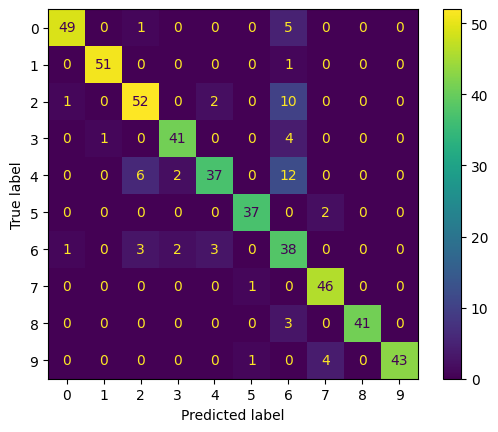

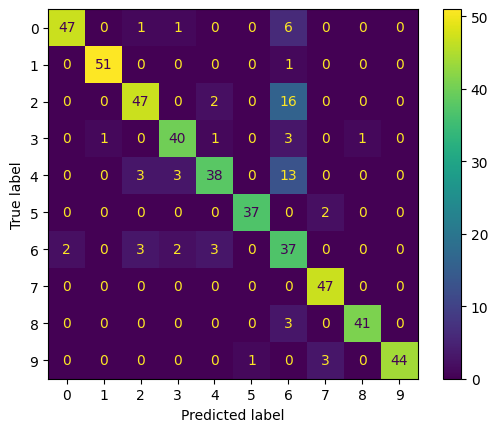

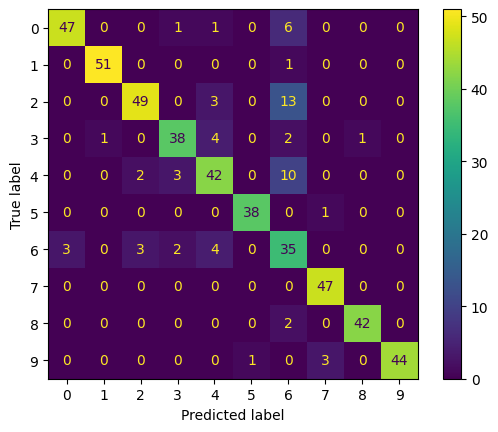

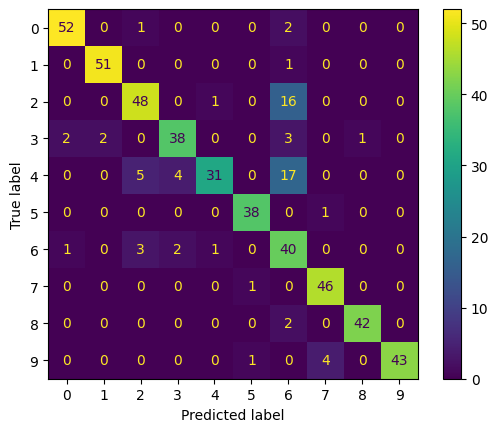

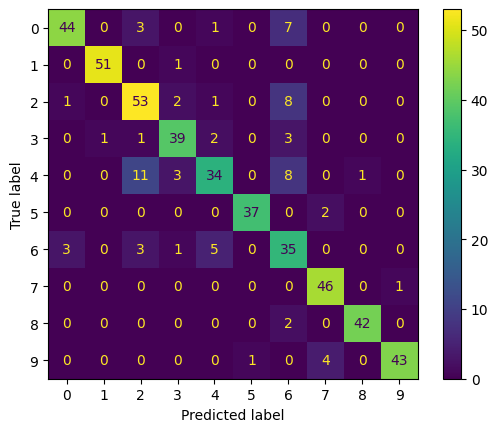

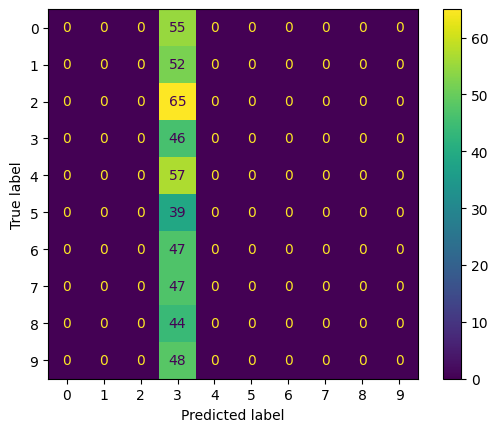

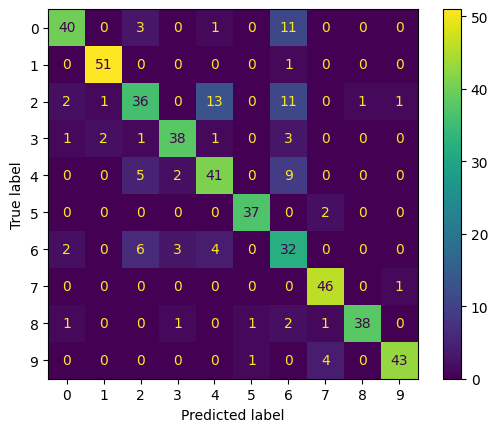

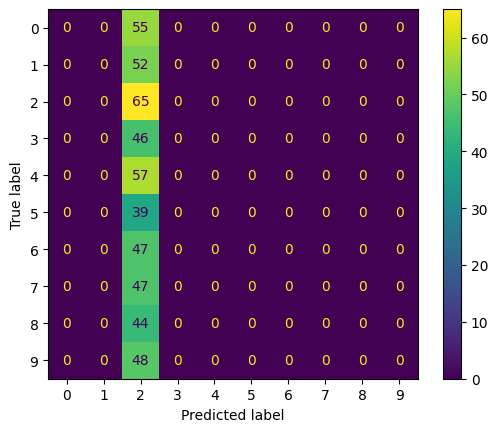

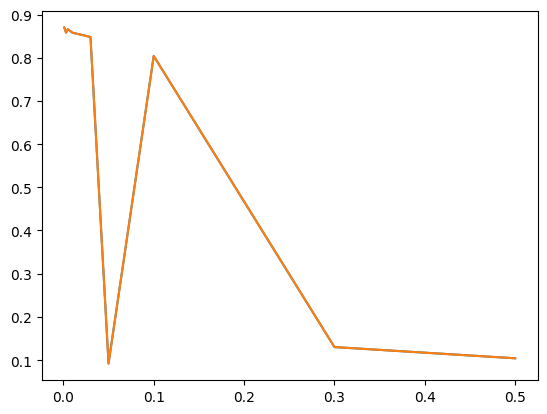

In [ ]:
lrs = [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5]
epochs = 15
accuracies = []
precisions = []
for lr_idx in lrs:
  a, p = train_test(CNN([CB2(1, 32, 3, 1, 1, 2, 2, 0)], 32*7*7*4, 10), epochs, lr_idx)
  plt.plot()
  accuracies.append(a)
  precisions.append(p)
  lr_idx *= 2

plt.subplot()
plt.plot(lrs, accuracies)
plt.plot(lrs, precisions)


CNN(
  (stack): Sequential(
    (0): CB2(
      (stack): Sequential(
        (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


  7%|▋         | 1/15 [00:01<00:19,  1.42s/it]

Epoch[1/15], Loss: 0.5697697997093201, accuracy: 0.82, precision: 0.82


 13%|█▎        | 2/15 [00:02<00:15,  1.21s/it]

Epoch[2/15], Loss: 0.6856224536895752, accuracy: 0.77, precision: 0.77


 20%|██        | 3/15 [00:03<00:13,  1.16s/it]

Epoch[3/15], Loss: 0.5649935007095337, accuracy: 0.8, precision: 0.8


 27%|██▋       | 4/15 [00:04<00:09,  1.12it/s]

Epoch[4/15], Loss: 0.5542449951171875, accuracy: 0.86, precision: 0.86


 33%|███▎      | 5/15 [00:04<00:07,  1.35it/s]

Epoch[5/15], Loss: 0.5242838263511658, accuracy: 0.86, precision: 0.86


 40%|████      | 6/15 [00:05<00:05,  1.52it/s]

Epoch[6/15], Loss: 0.5387596487998962, accuracy: 0.83, precision: 0.83


 47%|████▋     | 7/15 [00:05<00:04,  1.65it/s]

Epoch[7/15], Loss: 0.4491531252861023, accuracy: 0.86, precision: 0.86


 53%|█████▎    | 8/15 [00:06<00:04,  1.74it/s]

Epoch[8/15], Loss: 0.4511660039424896, accuracy: 0.86, precision: 0.86


 60%|██████    | 9/15 [00:06<00:03,  1.84it/s]

Epoch[9/15], Loss: 0.4199293255805969, accuracy: 0.87, precision: 0.87


 67%|██████▋   | 10/15 [00:07<00:02,  1.89it/s]

Epoch[10/15], Loss: 0.29019641876220703, accuracy: 0.9, precision: 0.9


 73%|███████▎  | 11/15 [00:07<00:02,  1.92it/s]

Epoch[11/15], Loss: 0.35110342502593994, accuracy: 0.88, precision: 0.88


 80%|████████  | 12/15 [00:08<00:01,  1.94it/s]

Epoch[12/15], Loss: 0.273164838552475, accuracy: 0.94, precision: 0.94


 87%|████████▋ | 13/15 [00:08<00:01,  2.00it/s]

Epoch[13/15], Loss: 0.46399685740470886, accuracy: 0.83, precision: 0.83


 93%|█████████▎| 14/15 [00:08<00:00,  2.01it/s]

Epoch[14/15], Loss: 0.416826069355011, accuracy: 0.88, precision: 0.88


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

Epoch[15/15], Loss: 0.2660077214241028, accuracy: 0.93, precision: 0.93


test accuracy: 0.838, test precision: 0.838
Precision: 0.838, Accuracy: 0.838


(0.838, 0.838)

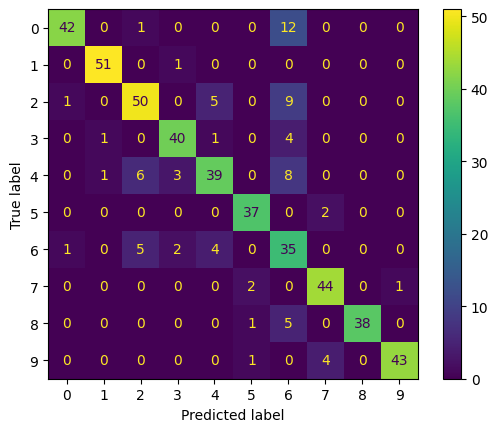

In [ ]:
train_test(CNN([CB2(1, 32, 5, 3, 2, 2, 2, 0)], 2 * 2 * 32, 10), 15, 0.003)

In [ ]:
train_test(CNN([CB1(1, 16, 5, 2, 2, 3, 2, 1), CB2(16, 64, 5, 2, )], ), 20, 0.003)

TypeError: CNN.__init__() missing 2 required positional arguments: 'linear_in' and 'linear_out'